In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from typing import Tuple, Union, List, Callable
import torch.optim as optim
from torch.optim import SGD
from vit_pytorch import ViT

import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

from DeepFake_util import *



In [47]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Preparing data
dataset_root = './Dataset/Subset_data'
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_root, "Train"), transform=transform)
validation_dataset = datasets.ImageFolder(root=os.path.join(dataset_root, "Valid"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_root, "Test"), transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

print("Train Loader: ", len(train_loader))
print("Test Loader: ", len(test_loader))
print("Valid Loader: ", len(validation_loader))

Train Loader:  40
Test Loader:  8
Valid Loader:  7


Classes: ['Fake', 'Real']


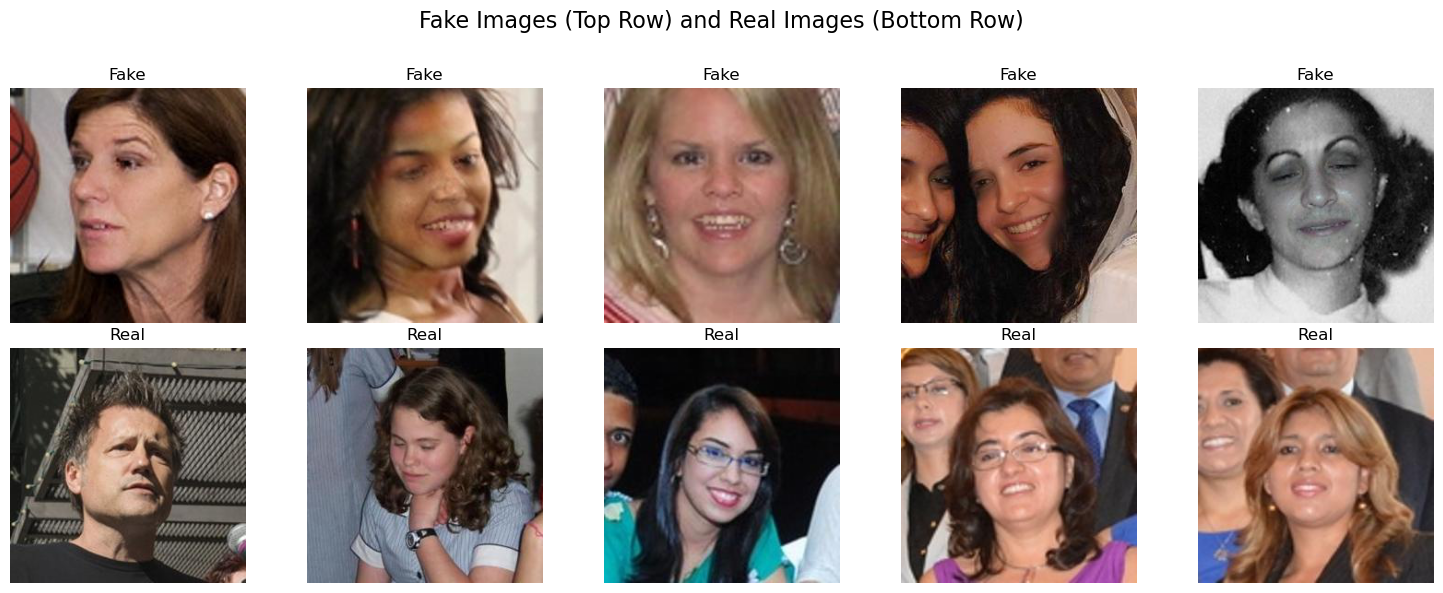

In [46]:
# check the dataset
classes = train_dataset.classes
print(f"Classes: {classes}")

# Function to denormalize the images for visualization
def denormalize(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from tensor (C, H, W) to numpy (H, W, C)
    # Undo normalization (mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    img = img * 0.5 + 0.5  # Scale back to [0, 1] for proper display
    img = np.clip(img, 0, 1)  # Ensure values are in valid range
    return img

# Function to plot 5 real and 5 fake images
def plot_examples(dataset, num_examples_per_class=5):
    real_count = 0
    fake_count = 0
    real_images = []
    fake_images = []

    # Iterate through the dataset to collect examples
    for img, label in dataset:
        if label == 0 and fake_count < num_examples_per_class:  # Class 0: Fake
            fake_images.append(img)
            fake_count += 1
        elif label == 1 and real_count < num_examples_per_class:  # Class 1: Real
            real_images.append(img)
            real_count += 1

        # Stop when we have enough examples for both classes
        if fake_count >= num_examples_per_class and real_count >= num_examples_per_class:
            break

    # Plot the examples
    fig, axes = plt.subplots(2, num_examples_per_class, figsize=(15, 6))
    fig.suptitle("Fake Images (Top Row) and Real Images (Bottom Row)", fontsize=16)

    for i in range(num_examples_per_class):
        # Plot fake images (top row)
        axes[0, i].imshow(denormalize(fake_images[i]))
        axes[0, i].axis('off')
        axes[0, i].set_title('Fake')

        # Plot real images (bottom row)
        axes[1, i].imshow(denormalize(real_images[i]))
        axes[1, i].axis('off')
        axes[1, i].set_title('Real')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    return real_images, fake_images

# Call the function to plot examples
real_images, fake_images = plot_examples(train_dataset, num_examples_per_class=5)

In [48]:
class DeepfakeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepfakeClassifier, self).__init__()
        
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.batch_norm = nn.BatchNorm2d(16)
        
        # Vision Transformer for classification
        self.vit = ViT(
            image_size=64,         # Size of input image patches (derived from feature map size)
            channels=16,
            patch_size=4,          # Patch size for the transformer
            num_classes=num_classes,  # Number of classes for classification
            dim=256,               # Transformer embedding dimension
            depth=5,               # Depth of transformer
            heads=12,               # Number of transformer heads
            mlp_dim=512,           # Dimension of the MLP within the transformer
            dropout=0.5,
            emb_dropout=0.5
        )
        
        # Linear classification head
        # self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # Convolutional feature extraction
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.batch_norm(x)  # Output size: (batch, 256, H/8, W/8)
        
        # Reshape convolutional feature maps to sequence of tokens
        # batch_size, channels, height, width = x.size()
        # x = x.permute(0, 2, 3, 1).view(batch_size, -1, channels)
        # patch_size = 8
        # x = x.reshape(batch_size, channels, height // patch_size, patch_size, width // patch_size, patch_size)
        # x = x.permute(0, 2, 4, 3, 5, 1).contiguous().view(batch_size, -1, patch_size * patch_size * channels)  # (batch_size, num_patches, channels)

        # Vision Transformer
        x = self.vit(x)

        # Classification head
        #  x = self.fc(x)

        return x

In [29]:
def train(
    model: nn.Module, optimizer: SGD,
    train_loader: DataLoader, val_loader: DataLoader,
    epochs: int = 20,
    batch_size: int = 256,
    checkpoint_path: str = "checkpoint.pth",
    resume: bool = False
    ) -> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Trains a model for the specified number of epochs using the loaders.
    Optionally resumes training from a checkpoint.

    Args:
    - model (nn.Module): The model to be trained.
    - optimizer (SGD): The optimizer used for training.
    - train_loader (DataLoader): DataLoader for training data.
    - val_loader (DataLoader): DataLoader for validation data.
    - epochs (int): Number of epochs to train.
    - batch_size (int): Batch size for training.
    - checkpoint_path (str): Path to save or load checkpoints.
    - resume (bool): Whether to resume training from the checkpoint.

    Returns:
    Lists of training loss, training accuracy, validation loss, validation accuracy for each epoch.
    """

    # Load checkpoint if resume is True and checkpoint exists
    start_epoch = 0
    if resume and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint['train_losses']
        train_accuracies = checkpoint['train_accuracies']
        val_losses = checkpoint['val_losses']
        val_accuracies = checkpoint['val_accuracies']
        print(f"Resuming training from epoch {start_epoch}")
    else:
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

    loss = nn.CrossEntropyLoss()

    for e in tqdm(range(start_epoch, epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        # Main training loop; iterate over train_loader. The loop
        # terminates when the train loader finishes iterating, which is one epoch.
        for (x_batch, labels) in train_loader:
            x_batch, labels = x_batch.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            labels_pred = model(x_batch)
            batch_loss = loss(labels_pred, labels)
            train_loss += batch_loss.item()

            labels_pred_max = torch.argmax(labels_pred, 1)
            batch_acc = torch.sum(labels_pred_max == labels)
            train_acc += batch_acc.item()

            batch_loss.backward()
            optimizer.step()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc / (batch_size * len(train_loader)))

        # Validation loop; use .no_grad() context manager to save memory.
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for (v_batch, labels) in val_loader:
                v_batch, labels = v_batch.to(DEVICE), labels.to(DEVICE)
                labels_pred = model(v_batch)
                v_batch_loss = loss(labels_pred, labels)
                val_loss += v_batch_loss.item()

                v_pred_max = torch.argmax(labels_pred, 1)
                batch_acc = torch.sum(v_pred_max == labels)
                val_acc += batch_acc.item()

            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_acc / (batch_size * len(val_loader)))

        # Save checkpoint every 5 epochs
        if (e + 1) % 5 == 0:
            checkpoint = {
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies
            }
            torch.save(checkpoint, checkpoint_path)

    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
model = DeepfakeClassifier(num_classes=2).to(DEVICE)
epochs = 200
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
checkpoint_path = "checkpoint_larger_data"
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=validation_loader,
    epochs=epochs,
    batch_size=256,
    resume=True,
    checkpoint_path=checkpoint_path
)

  0%|          | 1/200 [02:27<8:09:03, 147.45s/it]


KeyboardInterrupt: 

C:\Users\li290\AppData\Local\Temp\ipykernel_28024\4128096446.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


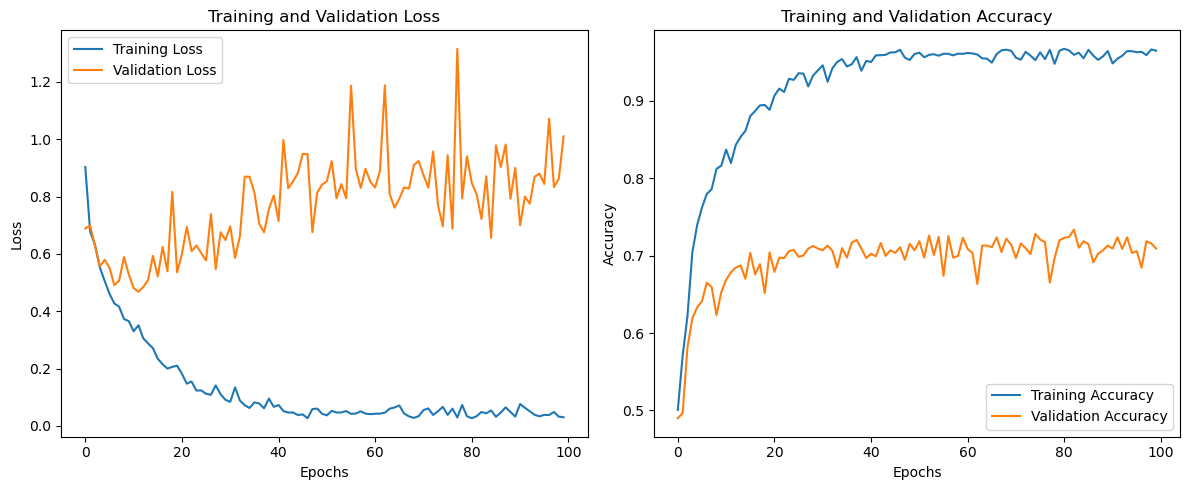

In [39]:
checkpoint_path = "checkpoint.pth"
checkpoint = torch.load(checkpoint_path)

# Extract training and validation metrics
train_losses = checkpoint['train_losses']
train_accuracies = checkpoint['train_accuracies']
val_losses = checkpoint['val_losses']
val_accuracies = checkpoint['val_accuracies']

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
def evaluate(
    model: nn.Module, loader: DataLoader, batch_size: int
) -> Tuple[float, float]:
    """Computes test loss and accuracy of model on loader."""
    loss = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for (batch, labels) in loader:
            batch, labels = batch.to(DEVICE), labels.to(DEVICE)
            y_batch_pred = model(batch)
            batch_loss = loss(y_batch_pred, labels)
            test_loss = test_loss + batch_loss.item()

            pred_max = torch.argmax(y_batch_pred, 1)
            batch_acc = torch.sum(pred_max == labels)
            test_acc = test_acc + batch_acc.item()
        test_loss = test_loss / len(loader)
        test_acc = test_acc / (batch_size * len(loader))
        return test_loss, test_acc

In [42]:
test_loss, test_acc = evaluate(model, test_loader, batch_size=256)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.74365234375


In [52]:
import gc
torch.cuda.empty_cache()
gc.collect()

2890

In [13]:
# # Try Face detector (Using Haar Cascade)
# face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# # Function to select the best face (most centered or largest)
# def select_best_face(faces, image_shape):
#     img_center_x, img_center_y = image_shape[1] // 2, image_shape[0] // 2
#     best_face = None
#     min_distance = float('inf')

#     for (x, y, w, h) in faces:
#         # Calculate the center of the detected face
#         face_center_x, face_center_y = x + w // 2, y + h // 2
#         # Calculate Euclidean distance from the center of the image
#         distance = ((face_center_x - img_center_x) ** 2 + (face_center_y - img_center_y) ** 2) ** 0.5

#         # Update the best face if this one is closer to the image center
#         if distance < min_distance:
#             min_distance = distance
#             best_face = (x, y, w, h)

#     return best_face

# # Function to apply face detection on images and plot the results
# def detect_and_plot_faces(images, title):
#     fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
#     fig.suptitle(title, fontsize=16)

#     for i, img in enumerate(images):
#         # Denormalize and convert tensor to NumPy array
#         img_denorm = denormalize(img)  # Now in the range [0, 1]
#         img_np = (img_denorm * 255).astype(np.uint8)  # Convert to [0, 255] and uint8 for OpenCV

#         # Ensure img_np is indeed a NumPy array and its data type is uint8
#         if not isinstance(img_np, np.ndarray) or img_np.dtype != np.uint8:
#             raise ValueError(f"Image at index {i} is not a valid NumPy array of dtype uint8.")

#         # Convert RGB to BGR for OpenCV
#         img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

#         # Convert to grayscale for face detection
#         gray_image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

#         # Detect faces in the image
#         faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

#         if len(faces) > 0:
#             # Select the best face (most central)
#             x, y, w, h = select_best_face(faces, img_bgr.shape)
#             # Crop and resize the face
#             cropped_face = img_np[y:y+h, x:x+w]
#             cropped_face_resized = cv2.resize(cropped_face, (224, 224))

#             # Plot the detected and cropped face
#             axes[i].imshow(cropped_face_resized)
#         else:
#             # If no face is detected, display the original image
#             axes[i].imshow(img_denorm)

#         axes[i].axis('off')

#     plt.tight_layout()
#     plt.subplots_adjust(top=0.85)
#     plt.show()

# # Apply face detection on real and fake images
# detect_and_plot_faces(real_images, "Detected Faces in Real Images")
# detect_and_plot_faces(fake_images, "Detected Faces in Fake Images")


In [28]:
# dataset_root = './Dataset/Subset_data'
# face_data_path = './Dataset/Subset_data/Train/Fake'

# # Get all image file names from the directory
# image_files = [f for f in os.listdir(face_data_path) if os.path.isfile(os.path.join(face_data_path, f))]

# # Select 20 random images from the directory
# random_images = random.sample(image_files, min(20, len(image_files)))
# face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


# # Loop through the randomly selected images and apply face detection
# for i, image_name in enumerate(random_images):
#     image_path = os.path.join(face_data_path, image_name)
#     image = cv2.imread(image_path)

#     # Ensure the image is loaded correctly
#     if image is None:
#         print(f"Warning: Could not read image {image_path}. Skipping...")
#         continue

#     # Convert the image to grayscale for face detection
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Detect faces in the image
#     faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

#     # Plot the original image and the detected face(s)
#     plt.figure(figsize=(10, 5))

#     # Plot original image
#     plt.subplot(1, 2, 1)
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.title("Original Image")
#     plt.axis('off')

#     # If faces are detected, draw rectangles around them
#     if len(faces) > 0:
#         # Draw rectangles around detected faces
#         for (x, y, w, h) in faces:
#             cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

#         # Plot the image with detected faces
#         plt.subplot(1, 2, 2)
#         plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#         plt.title(f"Detected Faces in Image {i+1}")
#         plt.axis('off')
#     else:
#         plt.subplot(1, 2, 2)
#         plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#         plt.title(f"No Faces Detected in Image {i+1}")
#         plt.axis('off')

#     plt.tight_layout()
#     plt.show()